# California Housing Prices

Build a model of housing prices in California using the California census data. This data has metrics such as the population, median income, median housing price, and so on for each block group in California. Block groups are the smallest geographical unit for which the US Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people). We will just call them "districts" for short.

Your model should learn from this data and be able to **predict the median house value** in any district, given all the other metrics.

## Problem description

Given that all the data needed for this problem is available in one CSV file. Given we have to predict a numeric target attribute which is also provided in the data as a label, we'll need to build a **supervised regression model** with a **offline** approach.

## Data overview

In [1]:
import pandas as pd
import numpy as np

# https://numpy.org/doc/stable/reference/arrays.scalars.html
# https://numpy.org/doc/stable/reference/arrays.dtypes.html
# https://www.bbc.co.uk/bitesize/guides/zscvxfr/revision/3

# I'm type casting the data to save space in memory.
# Although the full CSV it's just ~1MB, it's generally useful to set a fitting type for each attribute.
housing = pd.read_csv(
    'housing.csv',
    dtype={
        'longitude': np.float32,
        'latitude': np.float32,
        'housing_median_age': np.uint8,
        'population': np.uint16,
        'households': np.uint16,
        'median_income': np.float32,
        'median_house_value': np.float32,
        'ocean_proximity': 'category'
    }
)
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           20640 non-null  float32 
 1   latitude            20640 non-null  float32 
 2   housing_median_age  20640 non-null  uint8   
 3   total_rooms         20640 non-null  float64 
 4   total_bedrooms      20433 non-null  float64 
 5   population          20640 non-null  uint16  
 6   households          20640 non-null  uint16  
 7   median_income       20640 non-null  float32 
 8   median_house_value  20640 non-null  float32 
 9   ocean_proximity     20640 non-null  category
dtypes: category(1), float32(4), float64(2), uint16(2), uint8(1)
memory usage: 766.3 KB


> You can check whether a column classified as `float` has integer numbers. The following command tells you whether all values are integers or there is at least one floating number.
>
> ```
> (housing['housing_median_age'] % 1 == 0).all()
> ```
>
> If the column has missing values, you can run
>
> ```
> (housing.dropna()['total_bedrooms'] % 1 == 0).all()
> ```
>
> The `dropna` removes the `NaN` values because the `% 1` operation on NaN doesn't equal zero, and this statement will return `False`.

In [2]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.230003,37.880001,41,880.0,129.0,322,126,8.3252,452600.0,NEAR BAY
1,-122.220001,37.860001,21,7099.0,1106.0,2401,1138,8.3014,358500.0,NEAR BAY
2,-122.239998,37.849998,52,1467.0,190.0,496,177,7.2574,352100.0,NEAR BAY
3,-122.250000,37.849998,52,1274.0,235.0,558,219,5.6431,341300.0,NEAR BAY
4,-122.250000,37.849998,52,1627.0,280.0,565,259,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.089996,39.480000,25,1665.0,374.0,845,330,1.5603,78100.0,INLAND
20636,-121.209999,39.490002,18,697.0,150.0,356,114,2.5568,77100.0,INLAND
20637,-121.220001,39.430000,17,2254.0,485.0,1007,433,1.7000,92300.0,INLAND
20638,-121.320000,39.430000,18,1860.0,409.0,741,349,1.8672,84700.0,INLAND


In [3]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569710,35.631863,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.812500
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.617188
min,-124.349998,32.540001,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800003,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.489998,34.259998,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010002,37.709999,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.309998,41.950001,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [4]:
housing[['ocean_proximity']].describe()

,ocean_proximity
count,20640
unique,5
top,<1H OCEAN
freq,9136


In [19]:
pd.DataFrame(housing['ocean_proximity'].value_counts())

,ocean_proximity
<1H OCEAN,7310
INLAND,5249
NEAR OCEAN,2108
NEAR BAY,1840
ISLAND,5


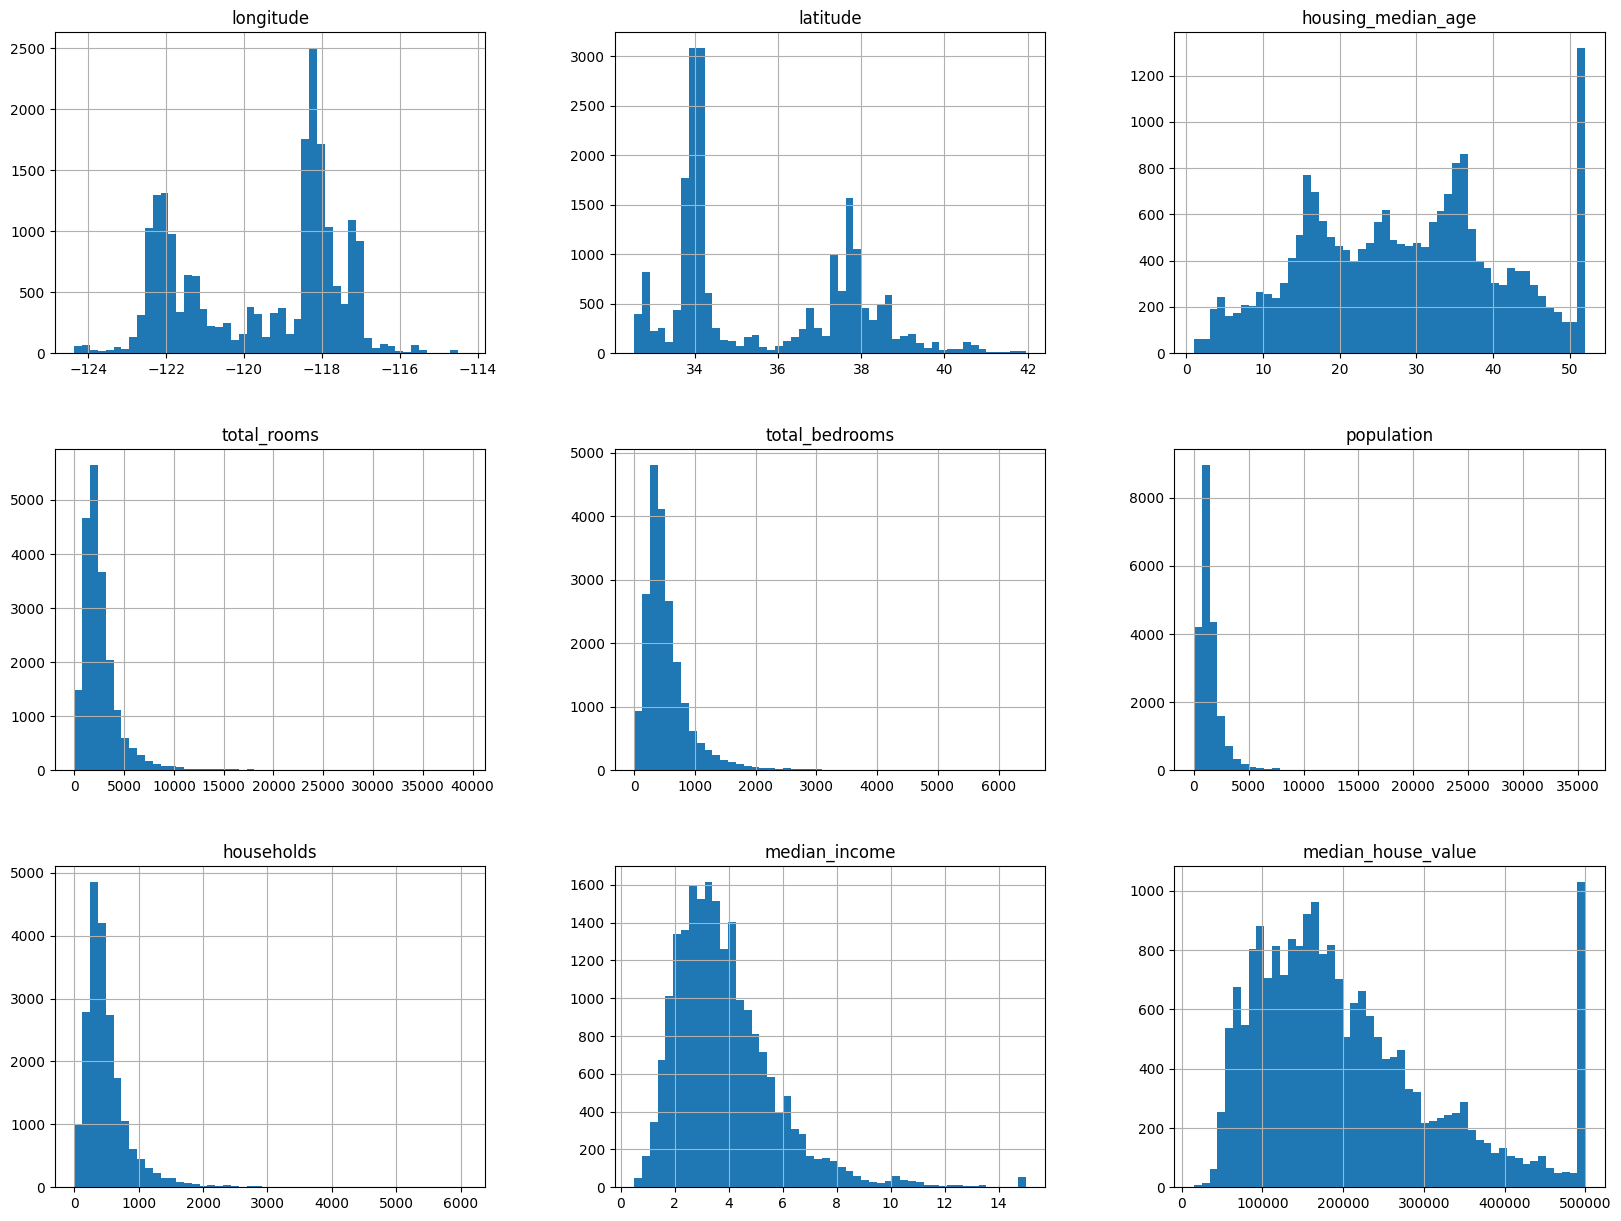

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

## Set aside the test set

By setting aside a portion of the dataset as a test set at this stage, allows me to prevent the so called ***data snooping bias***.

array([[<AxesSubplot: title={'center': 'median_income'}>]], dtype=object)

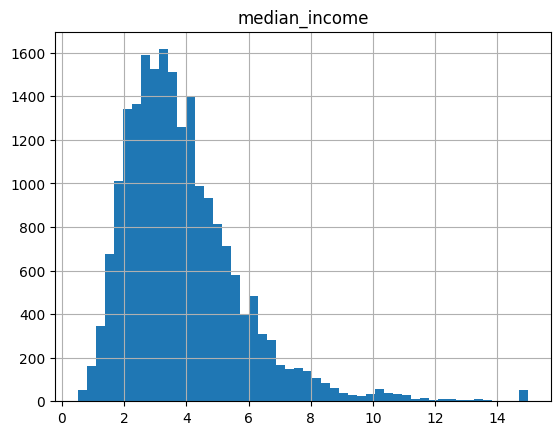

In [9]:
housing[['median_income']].hist(bins=50)

In [22]:
groups = 5
housing['median_income_group'] = pd.cut(
    housing['median_income'],
    bins=groups,
    labels=range(1, groups + 1)
)
pd.DataFrame(housing[['median_income_group']].value_counts(), columns=['Occurrences'])

,Occurrences
median_income_group,
1,7746
2,7270
3,1191
4,217
5,88


In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing['median_income_group']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [12]:
strat_train_set['median_income_group'].value_counts() / len(strat_train_set)

1    0.469113
2    0.440286
3    0.072129
4    0.013142
5    0.005329
Name: median_income_group, dtype: float64

In [13]:
strat_test_set['median_income_group'].value_counts() / len(strat_test_set)

1    0.469234
2    0.440407
3    0.071948
4    0.013081
5    0.005329
Name: median_income_group, dtype: float64

In [14]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('median_income_group', axis=1, inplace=True)

In [15]:
housing = strat_train_set.copy()

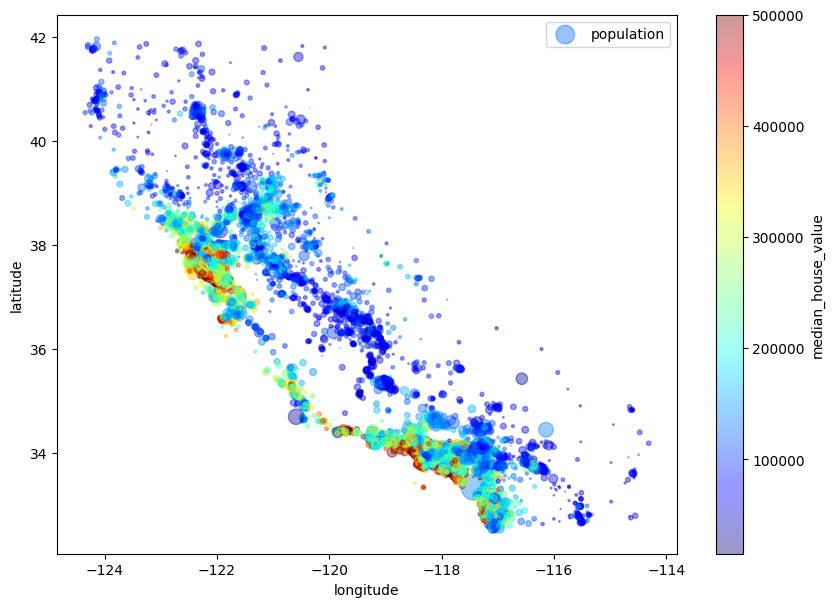

In [16]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

In [17]:
corr_matrix = housing.corr(method='pearson', numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.684937
total_rooms           0.132382
housing_median_age    0.111343
households            0.065330
total_bedrooms        0.049391
population           -0.026795
longitude            -0.048989
latitude             -0.142358
Name: median_house_value, dtype: float64